## Using BIC and AIC to determine optimal number of components for Medlatin1

- Refer to this page for how sklearn calculates the information criterions: https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

- Refer to this page for sklearn's tutorial on using gridsearch along with BIC to find the optimal number of components: https://scikit-learn.org/dev/auto_examples/mixture/plot_gmm_selection.html

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [2]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def gmm_aic_score(estimator, X):
    """Callable to pass to gridsearch that will use the AIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.aic(X)

def get_df_bic(grid_search):

    """
    Takes the result of the BIC grid search and creates a DataFrame
    that can be used to visualise the optimal number of k.
    """

    df_bic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]

    # re-invert the sign so we get the actual IC scores
    df_bic["mean_test_score"] = -df_bic["mean_test_score"]

    df_bic = df_bic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )

    return df_bic

def get_df_aic(grid_search):

    """
    Takes the result of the AIC grid search and creates a DataFrame
    that can be used to visualise the optimal number of k.
    """

    df_aic = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
        ]

    # re-invert the sign so we get the actual IC scores
    df_aic["mean_test_score"] = -df_aic["mean_test_score"]

    df_aic = df_aic.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "AIC score",
        }
    )

    return df_aic

In [3]:
# load the style vectors from csv files
path = 'csvfiles'
tfidf_dict = {}
for filename in os.listdir(path):
    if filename.startswith('tfidf'):
        ngram, rank = re.findall('\d+', filename)
        ngram = int(ngram)
        rank = int(rank)
        if ngram in tfidf_dict:
            tfidf_dict[ngram][rank] = np.genfromtxt(os.path.join(path, filename), delimiter=',')
        else:
            tfidf_dict[ngram] = {}
            tfidf_dict[ngram][rank] = np.genfromtxt(os.path.join(path, filename), delimiter=',')

In [5]:
grid_search_dict = {}
for ngram in tfidf_dict:
    grid_search_dict[ngram] = {}
    for rank in tfidf_dict[ngram]:
        grid_search_dict[ngram][rank] = {}
        X = tfidf_dict[ngram][rank]
        param_grid = {
            "n_components": range(1, 7),
            "covariance_type": ["spherical", "tied", "diag", "full"],
        }
        grid_search_bic = GridSearchCV(
            GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_bic_score
        )

        grid_search_bic.fit(X)
        df_bic = get_df_bic(grid_search_bic)
        grid_search_dict[ngram][rank]['bic'] = df_bic

        grid_search_aic = GridSearchCV(
            GaussianMixture(random_state=42), param_grid=param_grid, scoring=gmm_aic_score
        )

        grid_search_aic.fit(X)
        df_aic = get_df_aic(grid_search_aic)
        grid_search_dict[ngram][rank]['aic'] = df_aic

In [6]:
sns_blue = sns.color_palette()[0]
sns_orange = sns.color_palette()[1]

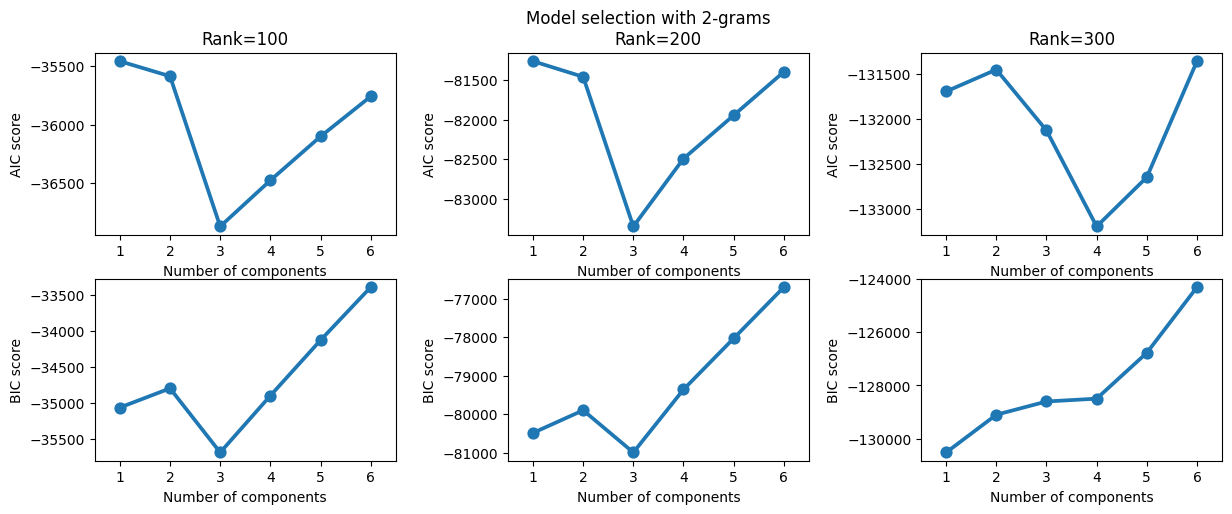

In [7]:
n = 2
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] != 'full') & (df_aic['Type of covariance'] != 'tied') & (df_aic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="AIC score",
        #hue="Type of covariance",
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] != 'full') & (df_bic['Type of covariance'] != 'tied') & (df_bic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="BIC score",
        #hue="Type of covariance",
        ax=axes[1][i]
    )

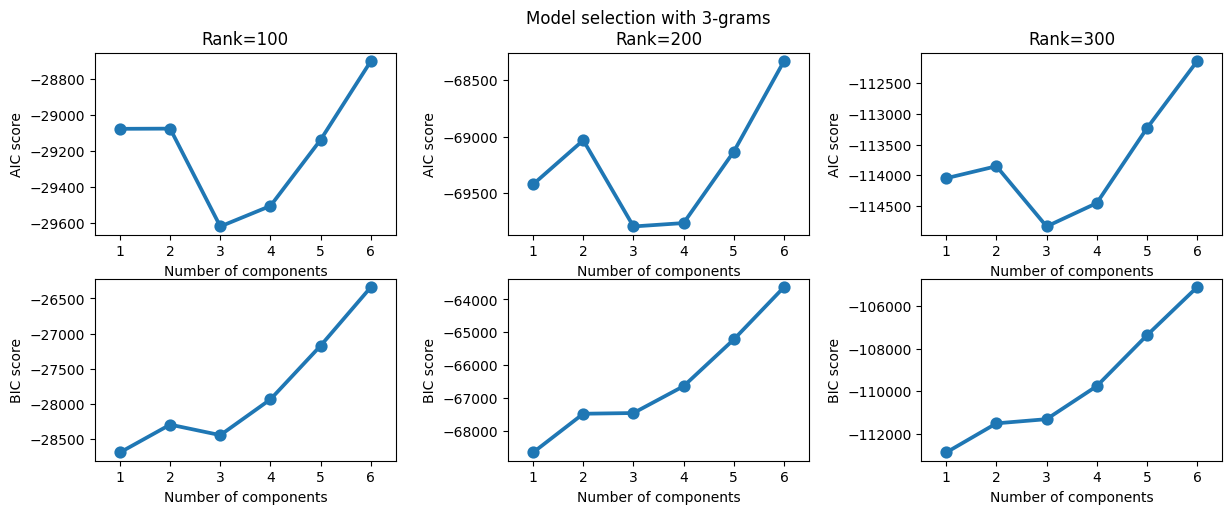

In [8]:
n = 3
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] != 'full') & (df_aic['Type of covariance'] != 'tied') & (df_aic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="AIC score",
        #hue="Type of covariance",
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] != 'full') & (df_bic['Type of covariance'] != 'tied') & (df_bic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="BIC score",
        #hue="Type of covariance",
        ax=axes[1][i]
    )

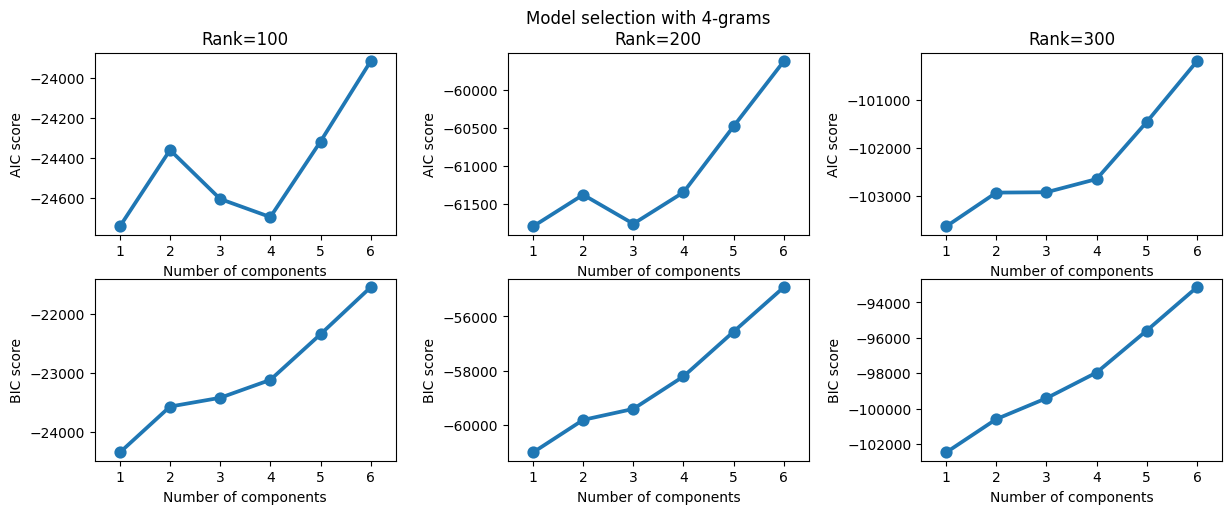

In [9]:
n = 4
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(12, 5)
fig.suptitle(f'Model selection with {n}-grams')
plt.tight_layout(w_pad=5)

for i, r in enumerate(sorted(tfidf_dict[n])):

    df_aic = grid_search_dict[n][r]['aic']
    aic_spher = grid_search_dict[n][r]['aic'][grid_search_dict[n][r]['aic']['Type of covariance'] == 'spherical']

    df_bic = grid_search_dict[n][r]['bic']
    bic_spher = grid_search_dict[n][r]['bic'][grid_search_dict[n][r]['bic']['Type of covariance'] == 'spherical']

    sns.pointplot(
        data=df_aic.loc[(df_aic['Type of covariance'] != 'full') & (df_aic['Type of covariance'] != 'tied') & (df_aic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="AIC score",
        #hue="Type of covariance",
        ax=axes[0][i]
    )

    axes[0][i].set_title(f'Rank={r}')

    sns.pointplot(
        data=df_bic.loc[(df_bic['Type of covariance'] != 'full') & (df_bic['Type of covariance'] != 'tied') & (df_bic['Type of covariance'] != 'diag')],
        x="Number of components",
        y="BIC score",
        #hue="Type of covariance",
        ax=axes[1][i]
    )

## Elbow method to determine optimal k for Medlatin1

In [10]:
inertias_dict = {}
for n in tfidf_dict:
    inertias_dict[n] = {}
    for r in tfidf_dict[n]:
        inertias_dict[n][r] = {}
        for k in range(1, 7):
            inertias_dict[n][r][k] = []
            for _ in range(100):
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(tfidf_dict[n][r])
                inertias_dict[n][r][k].append(kmeans.inertia_)

In [11]:
elbow_dict = {}
for n in inertias_dict:
    elbow_dict[n] = {}
    for r in inertias_dict[n]:
        elbow_dict[n][r] = {}
        for k in inertias_dict[n][r]:
            elbow_dict[n][r][k] = sum(inertias_dict[n][r][k])/len(inertias_dict[n][r][k])

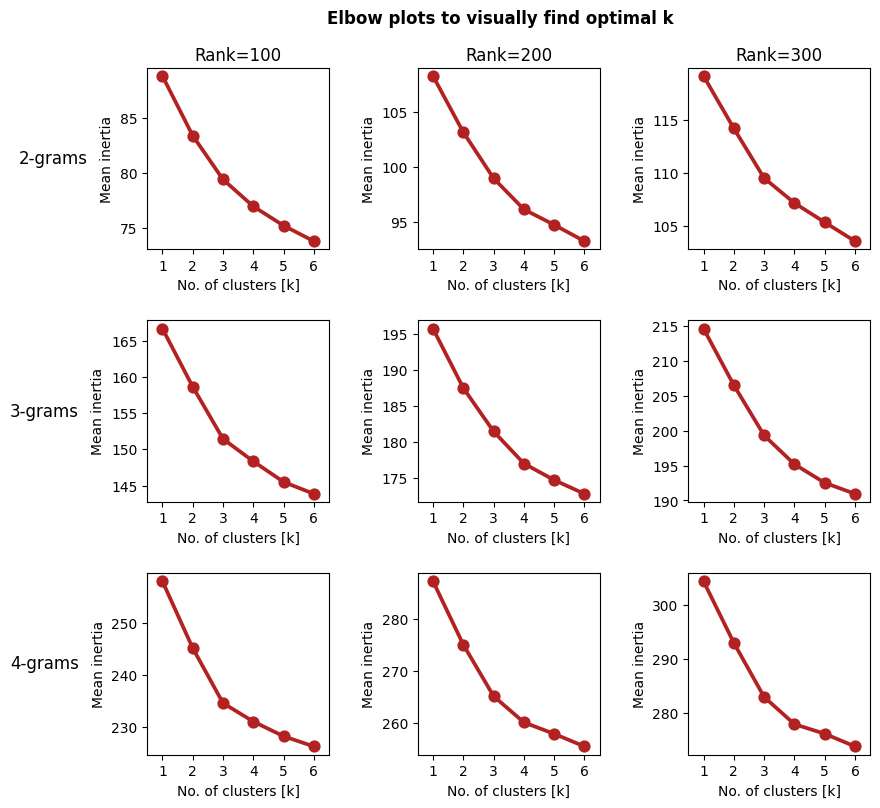

In [12]:
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
fig.suptitle('Elbow plots to visually find optimal k\n', fontweight='bold')
plt.tight_layout(w_pad=3, h_pad=3)
plt.setp(axes.flat, xlabel='No. of clusters [k]', ylabel='Mean inertia')
ngrams = [2, 3, 4]
ranks = [100, 200, 300]
pad=5
for ax, col in zip(axes[0], ranks):
    ax.annotate(f'Rank={col}', xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], ngrams):
    ax.annotate(f'{row}-grams', xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for idx, n in enumerate(sorted(elbow_dict)):
    for jdx, r in enumerate(sorted(elbow_dict[n])):
        sns.pointplot(y=elbow_dict[n][r].values(), x=elbow_dict[n][r].keys(), color='firebrick', ax=axes[idx][jdx])